# 4. Modelo de Random Forest Regressor - Pronóstico de Demanda Eléctrica

Este notebook implementa un modelo de **Random Forest Regressor** para predecir el consumo eléctrico horario de la región PJM East.

## Objetivo:
Construir un modelo de ensemble basado en **bagging** y compararlo con Gradient Boosting (boosting) para entender las diferencias entre estas técnicas.

## Contenido:
1. **Carga y Preparación de Datos**
2. **Ingeniería de Características (Feature Engineering)**
3. **División de Datos** - Train/Test cronológico
4. **Entrenamiento del Modelo**
5. **Evaluación del Modelo** - MAE, RMSE, R²
6. **Importancia de Variables (Feature Importance)**
7. **Análisis Comparativo con los Modelos de Regresión Lineal y Gradient Boosting**
8. **Conclusiones y Próximos Pasos**

---
## 1. Carga y Preparación de Datos

In [79]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Intentar importar XGBoost para comparación
from sklearn.ensemble import GradientBoostingRegressor
print("Usaremos sklearn.GradientBoostingRegressor")

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

print("\nLibrerías importadas correctamente")

Usaremos sklearn.GradientBoostingRegressor

Librerías importadas correctamente


In [80]:
# Cargar el dataset
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'])

# Ordenar por fecha y establecer como índice
df = df.sort_values('Datetime').reset_index(drop=True)
df.set_index('Datetime', inplace=True)

print("Dataset cargado correctamente")
print(f"\nInformación del Dataset:")
print(f"   - Registros: {len(df):,}")
print(f"   - Período: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"   - Duración: {(df.index.max() - df.index.min()).days / 365:.1f} años")
print(f"\nEstadísticas del consumo (PJME_MW):")
print(f"   - Promedio: {df['PJME_MW'].mean():,.0f} MW")
print(f"   - Desv. Estándar: {df['PJME_MW'].std():,.0f} MW")

Dataset cargado correctamente

Información del Dataset:
   - Registros: 145,366
   - Período: 2002-01-01 a 2018-08-03
   - Duración: 16.6 años

Estadísticas del consumo (PJME_MW):
   - Promedio: 32,080 MW
   - Desv. Estándar: 6,464 MW


---
## 2. Ingeniería de Características (Feature Engineering)

Usamos las mismas características que en los modelos anteriores para una comparación justa.

In [81]:
def create_features(df):

    df = df.copy()
    
    # Características temporales
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    # Variables de retraso (lags)
    df['lag_1'] = df['PJME_MW'].shift(1)
    df['lag_24'] = df['PJME_MW'].shift(24)
    
    return df

# Aplicar la función
df = create_features(df)

# Eliminar valores nulos
df = df.dropna()

print("Características creadas correctamente")
print(f"Registros después de limpiar nulos: {len(df):,}")

Características creadas correctamente
Registros después de limpiar nulos: 145,342


---
## 3. División de Datos: Entrenamiento y Test

In [82]:
# Definir la fecha de corte (misma que en modelos anteriores)
FECHA_CORTE = '2017-01-01'

# División cronológica
train = df.loc[df.index < FECHA_CORTE].copy()
test = df.loc[df.index >= FECHA_CORTE].copy()

# Definir características y objetivo
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1', 'lag_24']
TARGET = 'PJME_MW'

# Separar X e y
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

print("División  de datos")
print(f"\nFecha de corte: {FECHA_CORTE}")
print(f"\nEntrenamiento: {len(train):,} registros ({len(train)/len(df)*100:.1f}%)")
print(f"Test: {len(test):,} registros ({len(test)/len(df)*100:.1f}%)")
print(f"\nCaracterísticas: {len(FEATURES)}")

División  de datos

Fecha de corte: 2017-01-01

Entrenamiento: 131,446 registros (90.4%)
Test: 13,896 registros (9.6%)

Características: 8


---
## 4. Entrenamiento del Modelo Random Forest

### Configuración:
- **n_estimators = 200**: 200 árboles (buen balance precisión/velocidad)
- **max_depth = 15**: Limitar profundidad para evitar overfitting
- **n_jobs = -1**: Usar todos los núcleos del CPU (paralelización)
- **random_state = 42**: Reproducibilidad

In [83]:
# Configurar el modelo
print("Configuración del modelo")

modelo_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("\nModelo: RandomForestRegressor")
print("\nHiperparámetros:")
print("   - n_estimators: 200 (número de árboles)")
print("   - max_depth: 15 (profundidad máxima)")
print("   - min_samples_split: 5")
print("   - min_samples_leaf: 2")
print("   - max_features: sqrt (raíz cuadrada del total)")
print("   - n_jobs: -1 (todos los CPUs)")

Configuración del modelo

Modelo: RandomForestRegressor

Hiperparámetros:
   - n_estimators: 200 (número de árboles)
   - max_depth: 15 (profundidad máxima)
   - min_samples_split: 5
   - min_samples_leaf: 2
   - max_features: sqrt (raíz cuadrada del total)
   - n_jobs: -1 (todos los CPUs)


In [84]:
# Entrenar el modelo
import time

print("Entrenando el modelo...")

start_time = time.time()
modelo_rf.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\nModelo entrenado exitosamente")
print(f"\nTiempo de entrenamiento: {training_time:.2f} segundos ({training_time/60:.2f} minutos)")
print(f"Número de árboles creados: {modelo_rf.n_estimators}")

Entrenando el modelo...

Modelo entrenado exitosamente

Tiempo de entrenamiento: 8.98 segundos (0.15 minutos)
Número de árboles creados: 200


---
## 5. Evaluación del Modelo

In [85]:
# Realizar predicciones
y_pred_rf = modelo_rf.predict(X_test)

# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print("Métricas de Evaluación - Random Forest")
print(f"\nMAE (Mean Absolute Error): {mae_rf:,.2f} MW")
print(f"  En promedio, el modelo se equivoca por ±{mae_rf:,.0f} MW")
print(f"\nRMSE (Root Mean Squared Error): {rmse_rf:,.2f} MW")
print(f"  Penaliza más los errores grandes")
print(f"\nR² (Coeficiente de Determinación): {r2_rf:.4f}")
print(f"  El modelo explica el {r2_rf*100:.2f}% de la varianza")
print(f"\nMAPE (Mean Absolute Percentage Error): {mape_rf:.2f}%")
print(f"  Error porcentual promedio")
print(f"\nContexto:")
print(f"   - Consumo promedio en test: {y_test.mean():,.0f} MW")
print(f"   - Error relativo (MAE/Media): {(mae_rf/y_test.mean())*100:.2f}%")

Métricas de Evaluación - Random Forest

MAE (Mean Absolute Error): 597.59 MW
  En promedio, el modelo se equivoca por ±598 MW

RMSE (Root Mean Squared Error): 794.76 MW
  Penaliza más los errores grandes

R² (Coeficiente de Determinación): 0.9832
  El modelo explica el 98.32% de la varianza

MAPE (Mean Absolute Percentage Error): 1.92%
  Error porcentual promedio

Contexto:
   - Consumo promedio en test: 31,069 MW
   - Error relativo (MAE/Media): 1.92%


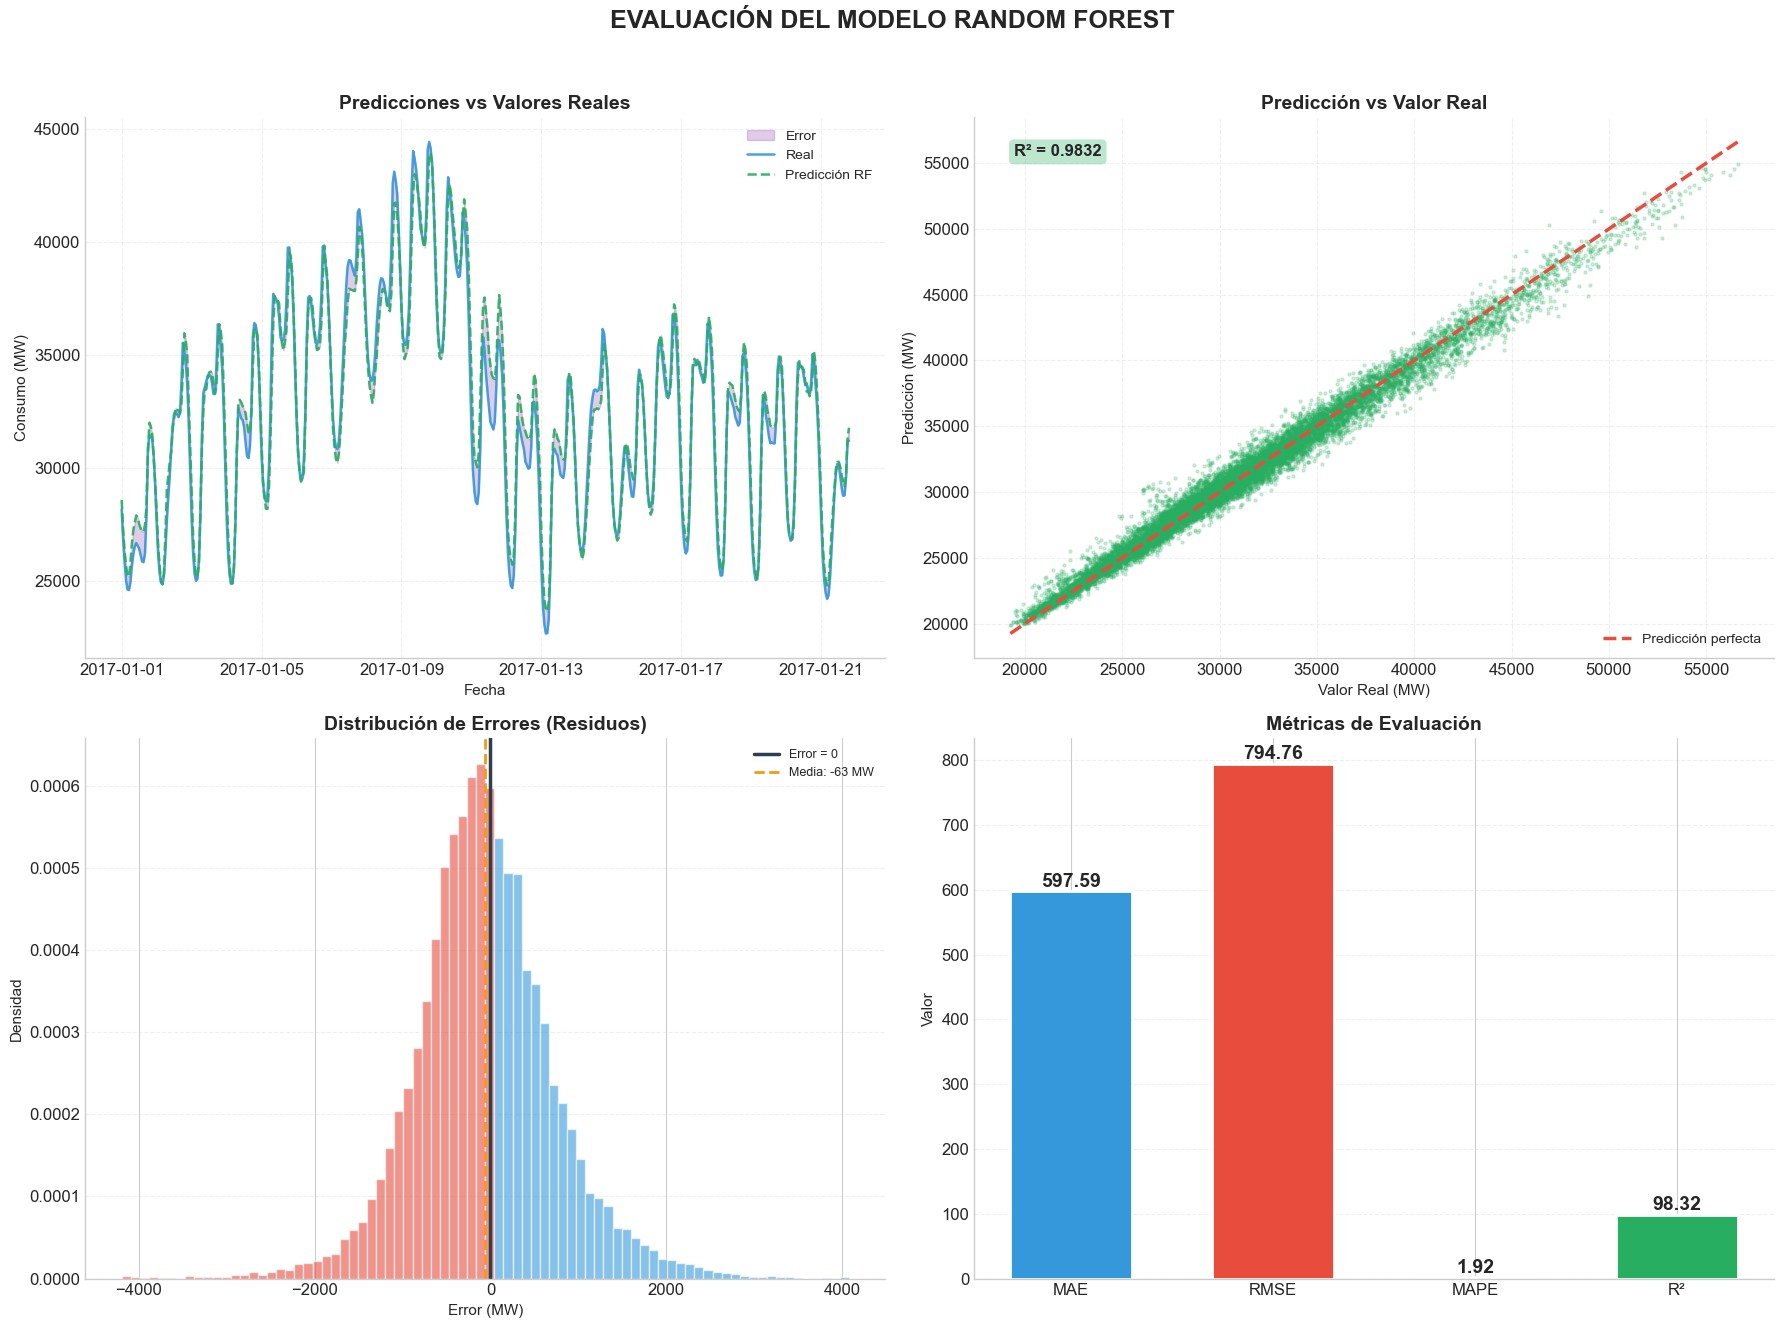

In [86]:
# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle('EVALUACIÓN DEL MODELO RANDOM FOREST', fontsize=18, fontweight='bold', y=1.02)

# Gráfico 1: Serie temporal
ax1 = axes[0, 0]
sample_size = 500

ax1.fill_between(test.index[:sample_size], 
                 y_test.values[:sample_size], 
                 y_pred_rf[:sample_size],
                 alpha=0.3, color='#9b59b6', label='Error')
ax1.plot(test.index[:sample_size], y_test.values[:sample_size], 
         color='#3498db', alpha=0.9, linewidth=1.8, label='Real')
ax1.plot(test.index[:sample_size], y_pred_rf[:sample_size], 
         color='#27ae60', alpha=0.9, linewidth=1.8, linestyle='--', label='Predicción RF')

ax1.set_title('Predicciones vs Valores Reales', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha', fontsize=11)
ax1.set_ylabel('Consumo (MW)', fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Gráfico 2: Scatter plot
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred_rf, alpha=0.2, color='#27ae60', s=5)
lims = [min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max())]
ax2.plot(lims, lims, color='#e74c3c', linestyle='--', linewidth=2.5, label='Predicción perfecta')

ax2.set_title('Predicción vs Valor Real', fontsize=14, fontweight='bold')
ax2.set_xlabel('Valor Real (MW)', fontsize=11)
ax2.set_ylabel('Predicción (MW)', fontsize=11)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.text(0.05, 0.95, f'R² = {r2_rf:.4f}', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top',
         bbox=dict(boxstyle='round', facecolor='#27ae60', edgecolor='none', alpha=0.3))

# Gráfico 3: Distribución de errores
ax3 = axes[1, 0]
errores_rf = y_test - y_pred_rf
n, bins, patches = ax3.hist(errores_rf, bins=80, color='#27ae60', edgecolor='white', alpha=0.7, density=True)

for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge < 0:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.6)
    else:
        patch.set_facecolor('#3498db')
        patch.set_alpha(0.6)

ax3.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=2.5, label='Error = 0')
ax3.axvline(x=errores_rf.mean(), color='#f39c12', linestyle='--', linewidth=2, 
            label=f'Media: {errores_rf.mean():+.0f} MW')

ax3.set_title('Distribución de Errores (Residuos)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Error (MW)', fontsize=11)
ax3.set_ylabel('Densidad', fontsize=11)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Gráfico 4: Métricas de Evaluación
ax4 = axes[1, 1]
metricas_nombres = ['MAE', 'RMSE', 'MAPE', 'R²']
metricas_valores = [mae_rf, rmse_rf, mape_rf, r2_rf*100]
colores = ['#3498db', '#e74c3c', '#f39c12', '#27ae60']

bars = ax4.bar(metricas_nombres, metricas_valores, color=colores, edgecolor='white', linewidth=2, width=0.6)

for bar, val in zip(bars, metricas_valores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:,.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax4.set_title('Métricas de Evaluación', fontsize=14, fontweight='bold')
ax4.set_ylabel('Valor', fontsize=11)
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

---
## 6. Importancia de Variables (Feature Importance)

Random Forest calcula la importancia basándose en cuánto reduce cada variable la impureza (varianza) en promedio a través de todos los árboles.

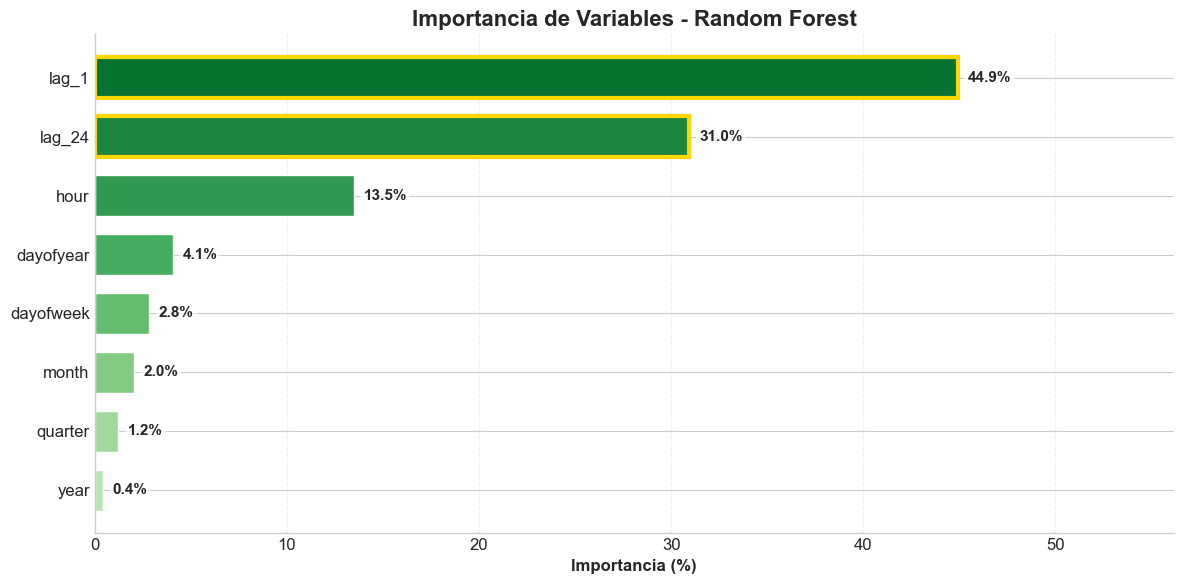

Interpretación de Importancia de Variables:

   lag_1: 44.9%
   lag_24: 31.0%
   hour: 13.5%

Random Forest también identifica los LAGs como las variables más importantes
Esto confirma la alta autocorrelación en la serie temporal


In [87]:
# Obtener importancia de variables
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': modelo_rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Normalizar a porcentaje
importance_df['Importance_Pct'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))

# Colores degradados verdes (para diferenciar de GB)
colors = plt.cm.Greens(np.linspace(0.3, 0.85, len(importance_df)))

bars = ax.barh(importance_df['Feature'], importance_df['Importance_Pct'], 
               color=colors, edgecolor='white', height=0.7)

# Destacar las 2 más importantes
top_2 = importance_df.nlargest(2, 'Importance')['Feature'].tolist()
for bar, feat in zip(bars, importance_df['Feature']):
    if feat in top_2:
        bar.set_edgecolor('#FFD700')
        bar.set_linewidth(3)

# Añadir valores
for bar, val in zip(bars, importance_df['Importance_Pct']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', ha='left', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7))

ax.set_xlabel('Importancia (%)', fontsize=12, fontweight='bold')
ax.set_title('Importancia de Variables - Random Forest', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')
ax.set_xlim(0, importance_df['Importance_Pct'].max() * 1.25)

plt.tight_layout()
plt.show()

print("Interpretación de Importancia de Variables:\n")
for i, row in importance_df.nlargest(3, 'Importance').iterrows():
    print(f"   {row['Feature']}: {row['Importance_Pct']:.1f}%")
print("\nRandom Forest también identifica los LAGs como las variables más importantes")
print("Esto confirma la alta autocorrelación en la serie temporal")

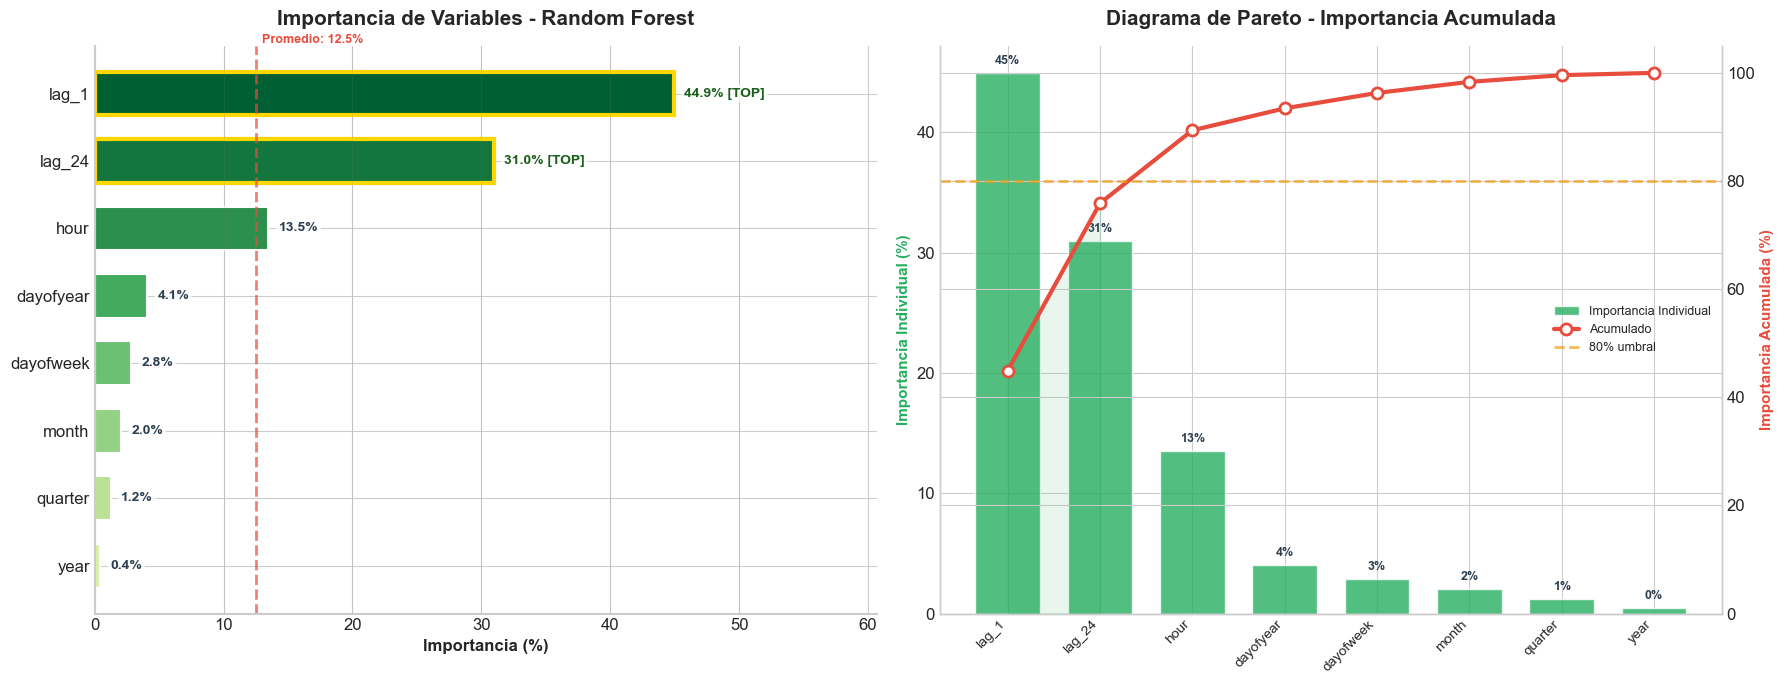

In [88]:
# Obtener importancia de variables
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': modelo_rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Normalizar a porcentaje
importance_df['Importance_Pct'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Calcular importancia acumulada
importance_df['Cumulative'] = importance_df['Importance_Pct'].cumsum()

# Visualizar con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Barras horizontales
ax1 = axes[0]

# Gradiente
n_bars = len(importance_df)
colors = plt.cm.YlGn(np.linspace(0.25, 0.9, n_bars))

# Barras principales
bars = ax1.barh(importance_df['Feature'], importance_df['Importance_Pct'], 
                color=colors, edgecolor='white', height=0.65, linewidth=1.5)

# Líneas de referencia
for i in range(0, int(importance_df['Importance_Pct'].max()) + 10, 10):
    ax1.axvline(x=i, color='gray', linestyle='-', linewidth=0.5, alpha=0.2)

# Destacar las 2 más importantes
top_2 = importance_df.nlargest(2, 'Importance')['Feature'].tolist()
for bar, feat in zip(bars, importance_df['Feature']):
    if feat in top_2:
        bar.set_edgecolor('#FFD700')
        bar.set_linewidth(3)
        bar.set_alpha(1.0)

# Añadir valores con indicador
for bar, (idx, row) in zip(bars, importance_df.iterrows()):
    val = row['Importance_Pct']
    feat = row['Feature']
    
    # Indicador [TOP] para las 2 más importantes
    suffix = ' [TOP]' if feat in top_2 else ''
    text_color = '#1a5f1a' if feat in top_2 else '#2c3e50'
    
    ax1.text(val + 0.8, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%{suffix}', va='center', ha='left', fontsize=10, fontweight='bold',
             color=text_color,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))

# Línea de promedio
avg_importance = importance_df['Importance_Pct'].mean()
ax1.axvline(x=avg_importance, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(avg_importance + 0.5, n_bars - 0.3, f'Promedio: {avg_importance:.1f}%', 
         fontsize=9, color='#e74c3c', fontweight='bold', va='bottom')

# Configuración de ejes
ax1.set_xlabel('Importancia (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('')
ax1.set_title('Importancia de Variables - Random Forest', fontsize=15, fontweight='bold', pad=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.set_xlim(0, importance_df['Importance_Pct'].max() * 1.35)

# Gráfico 2: Importancia Acumulada (Pareto)
ax2 = axes[1]

# Ordenar de mayor a menor para Pareto
pareto_df = importance_df.sort_values('Importance_Pct', ascending=False).reset_index(drop=True)
pareto_df['Cumulative'] = pareto_df['Importance_Pct'].cumsum()

x_pos = np.arange(len(pareto_df))

# Barras
bars2 = ax2.bar(x_pos, pareto_df['Importance_Pct'], color='#27ae60', edgecolor='white', 
                width=0.7, alpha=0.8, label='Importancia Individual')

# Línea de acumulado
ax2_twin = ax2.twinx()
ax2_twin.plot(x_pos, pareto_df['Cumulative'], color='#e74c3c', linewidth=3, 
              marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2,
              label='Acumulado')

# Línea de referencia
ax2_twin.axhline(y=80, color='#f39c12', linestyle='--', linewidth=2, alpha=0.7, label='80% umbral')
ax2_twin.fill_between(x_pos, 0, pareto_df['Cumulative'], 
                       where=pareto_df['Cumulative'] <= 80, alpha=0.1, color='#27ae60')

# Configuración
ax2.set_xticks(x_pos)
ax2.set_xticklabels(pareto_df['Feature'], rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Importancia Individual (%)', fontsize=11, fontweight='bold', color='#27ae60')
ax2_twin.set_ylabel('Importancia Acumulada (%)', fontsize=11, fontweight='bold', color='#e74c3c')
ax2.set_title('Diagrama de Pareto - Importancia Acumulada', fontsize=15, fontweight='bold', pad=15)

ax2_twin.set_ylim(0, 105)
ax2.spines['top'].set_visible(False)
ax2_twin.spines['top'].set_visible(False)

# Leyenda combinada
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=9)

# Añadir valores en las barras
for bar, val in zip(bars2, pareto_df['Importance_Pct']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()


In [89]:
# Interpretación detallada
print("Interpretación - Importancia de las variables")

print("\nTop 3 variables más importantes:")
for i, row in importance_df.nlargest(3, 'Importance').iterrows():
    print(f"   - {row['Feature']}: {row['Importance_Pct']:.1f}%")

# Análisis Pareto
vars_80 = pareto_df[pareto_df['Cumulative'] <= 80]['Feature'].tolist()
print(f"\n> Análisis de Pareto:")
print(f"   Las variables que explican el 80% de la importancia son:")
for v in vars_80:
    pct = pareto_df[pareto_df['Feature'] == v]['Importance_Pct'].values[0]
    print(f"   - {v}: {pct:.1f}%")

print(f"\n> Observaciones:")
print(f"   - Los LAGs (lag_1, lag_24) son las variables dominantes")
print(f"   - Esto confirma la alta autocorrelación temporal de la demanda eléctrica")
print(f"   - Solo {len(vars_80)} de {len(FEATURES)} variables explican ~80% de la importancia")

Interpretación - Importancia de las variables

Top 3 variables más importantes:
   - lag_1: 44.9%
   - lag_24: 31.0%
   - hour: 13.5%

> Análisis de Pareto:
   Las variables que explican el 80% de la importancia son:
   - lag_1: 44.9%
   - lag_24: 31.0%

> Observaciones:
   - Los LAGs (lag_1, lag_24) son las variables dominantes
   - Esto confirma la alta autocorrelación temporal de la demanda eléctrica
   - Solo 2 de 8 variables explican ~80% de la importancia


---
## 7. Análisis Comparativo con los Modelos de Regresión Lineal y Gradient Boosting

Comparemos Random Forest con Regresión Lineal y Gradient Boosting.

In [90]:
# Entrenar Regresión Lineal
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

# Entrenar Gradient Boosting
modelo_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

modelo_gb.fit(X_train, y_train)
y_pred_gb = modelo_gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print("Modelos de comparación entrenados")

Modelos de comparación entrenados


In [91]:
# Crear tabla comparativa
comparacion = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest', 'Gradient Boosting'],
    'MAE (MW)': [mae_lr, mae_rf, mae_gb],
    'RMSE (MW)': [rmse_lr, rmse_rf, rmse_gb],
    'R²': [r2_lr, r2_rf, r2_gb],
    'MAPE (%)': [mape_lr, mape_rf, mape_gb]
})

# Identificar el mejor modelo para cada métrica
print("Comparación de Modelos:")
print("\n" + comparacion.to_string(index=False))

# Determinar ranking
print("\nRanking de Modelos (menor MAE = mejor):\n")
ranking = comparacion.sort_values('MAE (MW)')
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}. {row['Modelo']}: MAE = {row['MAE (MW)']:,.2f} MW | R² = {row['R²']:.4f}")

Comparación de Modelos:

           Modelo   MAE (MW)   RMSE (MW)       R²  MAPE (%)
 Regresión Lineal 976.562165 1250.441132 0.958312  3.154876
    Random Forest 597.594735  794.760228 0.983160  1.922377
Gradient Boosting 326.063941  438.079967 0.994883  1.033045

Ranking de Modelos (menor MAE = mejor):

   1. Gradient Boosting: MAE = 326.06 MW | R² = 0.9949
   2. Random Forest: MAE = 597.59 MW | R² = 0.9832
   3. Regresión Lineal: MAE = 976.56 MW | R² = 0.9583


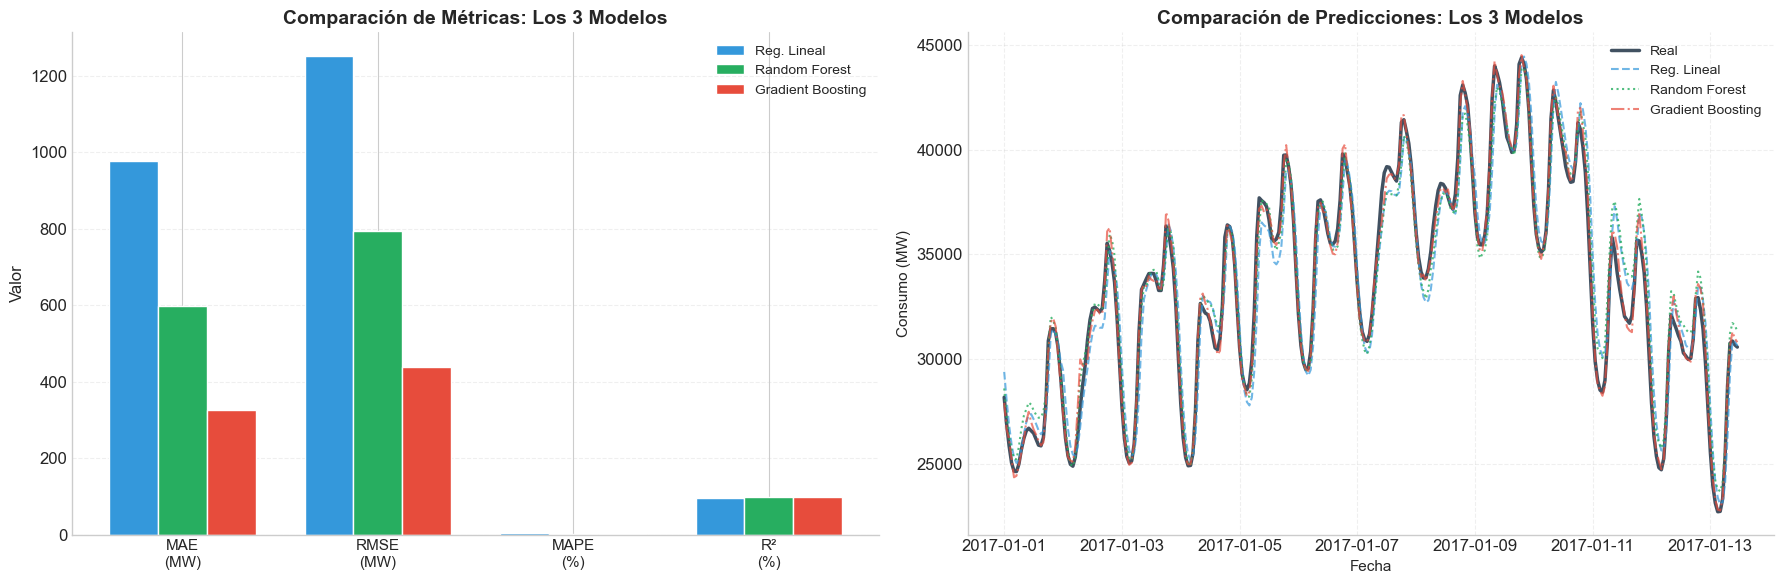

In [92]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Comparación de métricas
ax1 = axes[0]
x = np.arange(4)
width = 0.25

valores_lr = [mae_lr, rmse_lr, mape_lr, r2_lr*100]
valores_rf = [mae_rf, rmse_rf, mape_rf, r2_rf*100]
valores_gb = [mae_gb, rmse_gb, mape_gb, r2_gb*100]
labels = ['MAE\n(MW)', 'RMSE\n(MW)', 'MAPE\n(%)', 'R²\n(%)']

bars1 = ax1.bar(x - width, valores_lr, width, label='Reg. Lineal', color='#3498db', edgecolor='white')
bars2 = ax1.bar(x, valores_rf, width, label='Random Forest', color='#27ae60', edgecolor='white')
bars3 = ax1.bar(x + width, valores_gb, width, label='Gradient Boosting', color='#e74c3c', edgecolor='white')

ax1.set_ylabel('Valor', fontsize=12)
ax1.set_title('Comparación de Métricas: Los 3 Modelos', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Gráfico 2: Comparación de predicciones
ax2 = axes[1]
sample = 300

ax2.plot(test.index[:sample], y_test.values[:sample], 
         color='#2c3e50', linewidth=2.5, label='Real', alpha=0.9)
ax2.plot(test.index[:sample], y_pred_lr[:sample], 
         color='#3498db', linewidth=1.5, linestyle='--', label='Reg. Lineal', alpha=0.7)
ax2.plot(test.index[:sample], y_pred_rf[:sample], 
         color='#27ae60', linewidth=1.5, linestyle=':', label='Random Forest', alpha=0.8)
ax2.plot(test.index[:sample], y_pred_gb[:sample], 
         color='#e74c3c', linewidth=1.5, linestyle='-.', label='Gradient Boosting', alpha=0.7)

ax2.set_title('Comparación de Predicciones: Los 3 Modelos', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=11)
ax2.set_ylabel('Consumo (MW)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [93]:
# Análisis de diferencias entre modelos
print("\nAnálisis de diferencias entre modelos:")

# Mejor modelo
mejor_modelo = comparacion.loc[comparacion['MAE (MW)'].idxmin(), 'Modelo']
mejor_mae = comparacion['MAE (MW)'].min()
mejor_r2 = comparacion.loc[comparacion['MAE (MW)'].idxmin(), 'R²']

print(f"\nMejor Modelo: {mejor_modelo}")
print(f"  - MAE: {mejor_mae:,.2f} MW")
print(f"  - R²: {mejor_r2:.4f}")

# Comparación RF vs GB
print(f"\n> Random Forest vs Gradient Boosting:")
if mae_rf < mae_gb:
    diff = ((mae_gb - mae_rf) / mae_gb) * 100
    print(f"  Random Forest es {diff:.1f}% mejor en MAE")
else:
    diff = ((mae_rf - mae_gb) / mae_rf) * 100
    print(f"  Gradient Boosting es {diff:.1f}% mejor en MAE")



Análisis de diferencias entre modelos:

Mejor Modelo: Gradient Boosting
  - MAE: 326.06 MW
  - R²: 0.9949

> Random Forest vs Gradient Boosting:
  Gradient Boosting es 45.4% mejor en MAE


### 7. Observaciones y Recomendaciones Finales

In [94]:
print(f"\n Observaciones Detalladas:")
print(f"")
print(f"  Sobre las variables explicativas:")
print(f"  - lag_1 es la variable más importante: el consumo tiene alta inercia")
print(f"  - lag_24 captura el patrón diario (mismo horario del día anterior)")
print(f"  - Las variables temporales complementan pero no dominan")
print(f"  - La hora del día es clave para patrones intradiarios")
print(f"")
print(f"  Sobre los modelos:")
print(f"  - GB supera a RF porque optimiza secuencialmente los errores")
print(f"  - RF es más robusto ante outliers y ruido en los datos")
print(f"  - RF entrena más rápido (n_jobs=-1 usa todos los CPUs)")
print(f"  - GB requiere más cuidado con hiperparámetros para evitar overfitting")
print(f"")
print(f"  Aplicación al Sector Eléctrico:")
print(f"  - Error de {mae_rf:,.0f} MW = {(mae_rf/y_test.mean())*100:.1f}% del consumo promedio")
print(f"  - Suficiente para planificación de despacho y compra de energía")
print(f"  - Para predicción horaria operativa, actualizar modelo frecuentemente")
print(f"  - Considerar añadir: temperatura, festivos, data de eventos especiales")
print(f"")


 Observaciones Detalladas:

  Sobre las variables explicativas:
  - lag_1 es la variable más importante: el consumo tiene alta inercia
  - lag_24 captura el patrón diario (mismo horario del día anterior)
  - Las variables temporales complementan pero no dominan
  - La hora del día es clave para patrones intradiarios

  Sobre los modelos:
  - GB supera a RF porque optimiza secuencialmente los errores
  - RF es más robusto ante outliers y ruido en los datos
  - RF entrena más rápido (n_jobs=-1 usa todos los CPUs)
  - GB requiere más cuidado con hiperparámetros para evitar overfitting

  Aplicación al Sector Eléctrico:
  - Error de 598 MW = 1.9% del consumo promedio
  - Suficiente para planificación de despacho y compra de energía
  - Para predicción horaria operativa, actualizar modelo frecuentemente
  - Considerar añadir: temperatura, festivos, data de eventos especiales



In [95]:
print(f"Recomendaciones para futuros Análisis:")
print(f"")
print(f"  1. Selección del Modelo según Caso de Uso:")
print(f"     - Gradient Boosting: Ideal para pronósticos de mediano plazo (días/semanas)")
print(f"       donde la precisión es crítica, como planificación de compra de energía")
print(f"     - Random Forest: Preferible cuando se requiere velocidad de entrenamiento,")
print(f"       interpretabilidad o robustez ante datos ruidosos/outliers")
print(f"     - Regresión Lineal: Útil como baseline y para entender relaciones lineales")
print(f"")
print(f"  2. Mejora del Modelo con Nuevas Variables:")
print(f"     - Temperatura: Alta correlación con consumo (aire acondicionado/calefacción)")
print(f"     - Festivos y días especiales: Patrones de consumo atípicos")
print(f"     - Indicadores económicos: Actividad industrial, PIB regional")
print(f"     - Eventos masivos programados: Partidos de fútbol, conciertos masivos")
print(f"     - Pronóstico meteorológico: Nubosidad, humedad, viento")
print(f"")
print(f"  3. Estrategias de Ensemble Avanzadas:")
print(f"     - Stacking: Combinar predicciones de RF, GB y otros modelos con meta-learner")
print(f"     - Blending: Promediar predicciones ponderadas de múltiples modelos")
print(f"     - Voting: Usar la mediana de predicciones para mayor robustez")
print(f"")
print(f"  4. Mantenimiento y Monitoreo del Modelo:")
print(f"     - Reentrenar semanalmente o mensualmente con datos recientes")
print(f"     - Monitorear drift: degradación del rendimiento por cambios en patrones")
print(f"     - Implementar alertas si el error supera umbrales definidos")
print(f"     - Validar con backtesting antes de puesta en producción")

Recomendaciones para futuros Análisis:

  1. Selección del Modelo según Caso de Uso:
     - Gradient Boosting: Ideal para pronósticos de mediano plazo (días/semanas)
       donde la precisión es crítica, como planificación de compra de energía
     - Random Forest: Preferible cuando se requiere velocidad de entrenamiento,
       interpretabilidad o robustez ante datos ruidosos/outliers
     - Regresión Lineal: Útil como baseline y para entender relaciones lineales

  2. Mejora del Modelo con Nuevas Variables:
     - Temperatura: Alta correlación con consumo (aire acondicionado/calefacción)
     - Festivos y días especiales: Patrones de consumo atípicos
     - Indicadores económicos: Actividad industrial, PIB regional
     - Eventos masivos programados: Partidos de fútbol, conciertos masivos
     - Pronóstico meteorológico: Nubosidad, humedad, viento

  3. Estrategias de Ensemble Avanzadas:
     - Stacking: Combinar predicciones de RF, GB y otros modelos con meta-learner
     - Blending